In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
import seaborn
import cv2

In [3]:
def plot_grad_sim(x, sims, module, para):
    fig, ax = plt.subplots()
    #fig.suptitle(module+para)
    xp = np.array(x)
    for name,sim in sims.items():
        if module in name and para in name:
            sim = np.array(sim)
            name = name.replace(module,'')
            plt.scatter(xp, sim, label=name)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    ax.set_title(module+para)
    #ax.legend(loc='upper right')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('iters')
    ax.set_ylabel('Cosine similarity')
    ax.grid(True)
    plt.show()
    #fig.savefig(opt.save_path+'/{}{}_gradSim.png'.format(module,para))

In [4]:
def gradient_similarity(sims,grad1,grad2):
    for name in sims:
        g_1 = grad1[name]
        g_2 = grad2[name]
        g_1 = g_1.view(-1)
        g_2 = g_2.view(-1)
        g_1 = g_1.cpu().detach().numpy()
        g_2 = g_2.cpu().detach().numpy()
        sims[name].append(dot_product(g_1,g_2))


In [5]:
def compute_per_layer_pearsonc(grad_sim,acc1,acc2):
    p_task1 = {}
    p_task2 = {}
    for name, sim_value in grad_sim.items():
        p_task1[name]=pearsonr(np.array(acc1),np.array(sim_value))[0]
        p_task2[name]=pearsonr(np.array(acc2),np.array(sim_value))[0]
    return p_task1, p_task2
    

In [6]:
def multiplot(x,sims):
    for module in ['FeatureExtraction.','rnn_lang.']:
        for para in ['weight','bias']:
            plot_grad_sim(x,sims,module,para)

In [7]:
def plot_pearsonc(p_task1,lang1,p_task2,lang2):
    labels = p_task1.keys()
    #values = p_arabacc.values()
    fig, axs = plt.subplots(figsize=(20,8))
    axs.tick_params(axis='x', rotation=90)
    box = axs.get_position()
    axs.set_title('Comparing '+lang1+'-'+lang2+' per layer pearson correlation')
    axs.set_position([box.x0, box.y0, box.width * 0.85, box.height])
    plt.scatter(list(labels), list(p_task1.values()),label=lang1)
    plt.scatter(list(labels),list(p_task2.values()),label=lang2)
    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs.set_xlabel('layers')
    axs.set_ylabel('pearson co-relation between gradient similarity and lang accurcay')
    axs.grid(True)
    plt.show()

    

In [8]:
#compute euclidean distance between correlation vectors
def norm1(a,b):
    a = np.array(a)
    b = np.array(b)
    return 1-np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [9]:
def dot_product(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [10]:
def check_para_equal(pa,pb):
    res = True
    for name in pa.keys():
        if not torch.equal(pa[name],pb[name]):
            res = False
            break
    return res

In [ ]:
ta = torch.Tensor([[1,2],[3,5]])
tb = torch.Tensor([[1,2],[3,4]])
torch.equal(ta,tb)

# 1. Multi-Task Acc GradSim  Pearson Correlation (MTAGS-PC)  

In [11]:
#AB
acc_AB_A = [1.915,5.426,10.106,13.085,19.149,20.319,19.894,23.723,26.170,24.787]
acc_AB_B = [5.591,19.441,28.463,29.352,35.070,31.258,36.595,32.656,36.595,36.341]

#BH
acc_BH_B = [8.259,29.860,36.849,37.357,41.550,39.517,43.456,42.058,42.313,45.743]
acc_BH_H = [8.418,34.056,38.903,45.281,45.153,45.918,47.449,48.214,48.214,47.959]

#AH
acc_AH_A = [2.553,5.319,10.638,13.830,17.553,17.766,21.915,20.319,24.574,25.426]
acc_AH_H = [7.526,19.898,28.827,32.398,33.418,34.184,36.990,38.138,39.668,39.031]

#pearsonr(np.array(acc_BH_B),np.array(acc_BH_H))

In [12]:
dumpAB = torch.load('gradinfo_AB.pth')
dumpBH = torch.load('gradinfo_BH_avg.pth')
dumpAH = torch.load('gradinfo_AH_avg.pth')
grad_sims_AB = dumpAB['grad_sims']
grad_sims_BH = dumpBH['grad_sims']
grad_sims_AH = dumpAH['grad_sims']
x = dumpAB['iter']
#grad_sims_AB

In [ ]:
metric = 0.0

'''for name, value in grad_sims_AB.items():
    l = grad_sims_AB[name]
    l = sum(l)/len(l)
    grad_sims_AB[name] = l'''

grad_sims_AB
'''for name, value in grad_sims_AB.items():
    metric += value
print(metric)'''

### Gradient similarity plot Arab and Bangla (multi task-without gradient averaging)

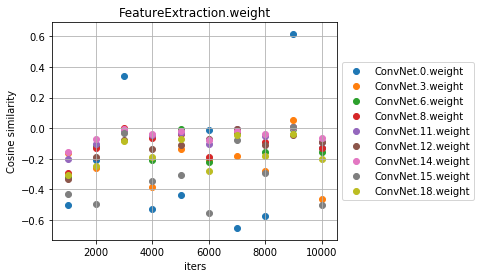

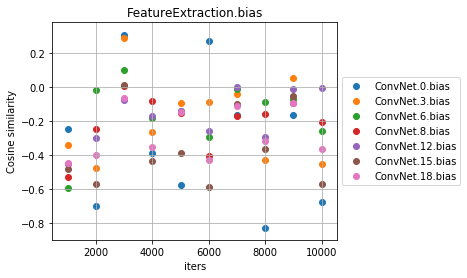

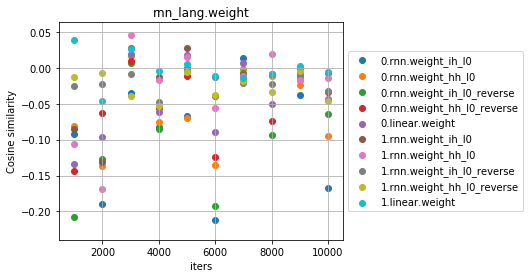

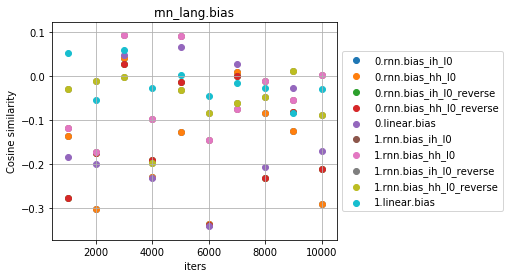

In [13]:
multiplot(x,grad_sims_AB)

### Gradient similarity plot Arab and Hindi (multi-task with gradient averaging)

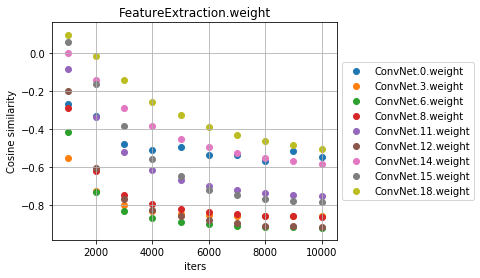

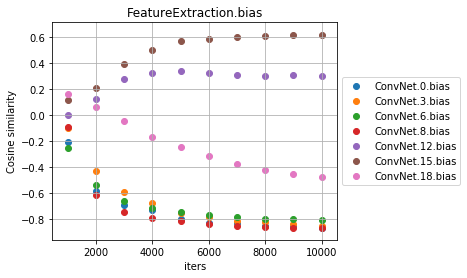

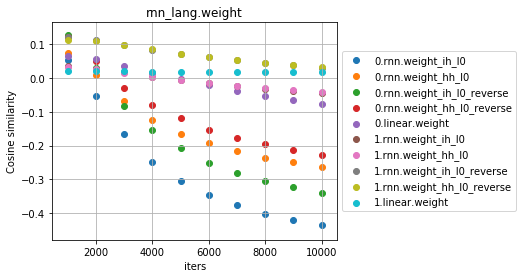

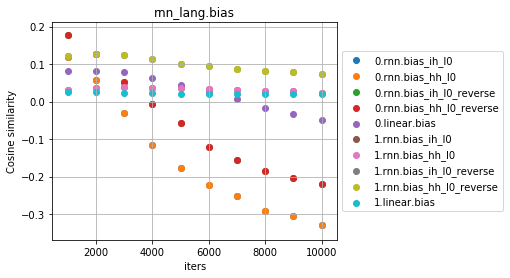

In [14]:
multiplot(x,grad_sims_AH)

### Gradient Similarity plot Bangla-Hindi (multi-task with gradient-averaging)

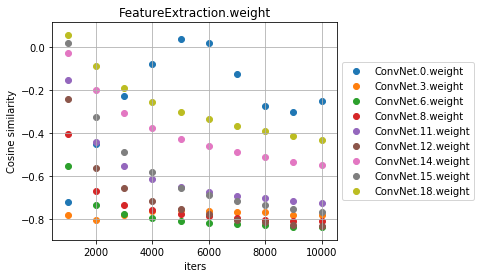

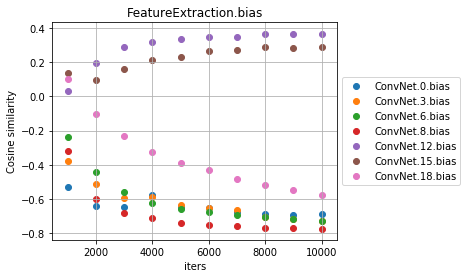

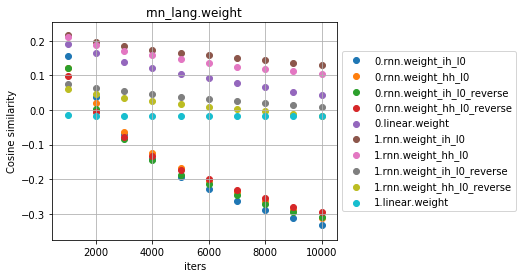

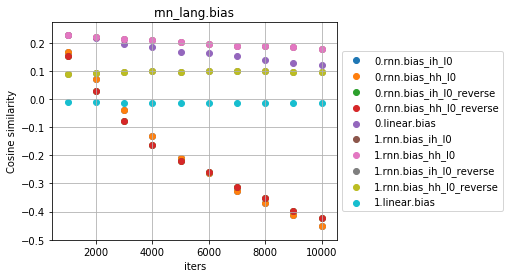

In [15]:
multiplot(x,grad_sims_BH)

In [ ]:
#metric1 = 0.0
#for name, value in grad_sims_BH.items():
#    l = grad_sims_BH[name]
#   l = sum(l)/len(l)
#    grad_sims_BH[name] = l
for name, value in grad_sims_BH.items():
    metric1 += value
print(metric1)

In [16]:
p_AH_A, p_AH_H = compute_per_layer_pearsonc(grad_sims_AH,acc_AH_A,acc_AH_H)
p_BH_B, p_BH_H = compute_per_layer_pearsonc(grad_sims_BH,acc_BH_B,acc_BH_H)
p_AB_A, p_AB_B = compute_per_layer_pearsonc(grad_sims_AB,acc_AB_A,acc_AB_B)

In [17]:
#AH
sim_effect_AH_A = np.linalg.norm(list(p_AH_A.values()))
sim_effect_AH_H = np.linalg.norm(list(p_AH_H.values()))
#BH
sim_effect_BH_B = np.linalg.norm(list(p_BH_B.values()))
sim_effect_BH_H = np.linalg.norm(list(p_BH_H.values()))
#AB
sim_effect_AB_A = np.linalg.norm(list(p_AB_A.values()))
sim_effect_AB_B = np.linalg.norm(list(p_AB_B.values()))

print("AH")
print('sim_effect on A',sim_effect_AH_A)
print('sim_effect on H',sim_effect_AH_H)
print("AB")
print('sim_effect on A',sim_effect_AB_A)
print('sim_effect on B',sim_effect_AB_B)
print("BH")
print('sim_effect on B',sim_effect_BH_B)
print('sim_effect on H',sim_effect_BH_H)

AH
sim_effect on A 5.555470605819416
sim_effect on H 5.506789862691154
AB
sim_effect on A 2.180574990645519
sim_effect on B 3.1080679996973273
BH
sim_effect on B 5.3660674061593125
sim_effect on H 5.316975709883231


## 1.1 Comparing arab-hin per layer pearson correlation

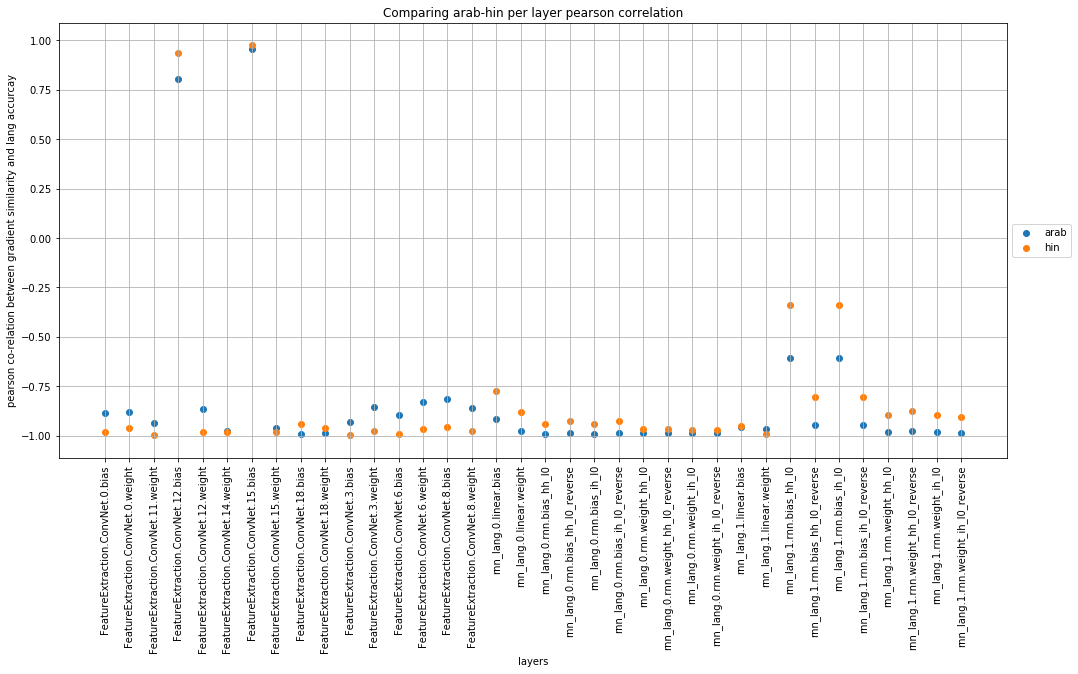

In [18]:
plot_pearsonc(p_AH_A,'arab',p_AH_H,'hin')

## 1.2 Comparing hin-ban per layer pearson correlation

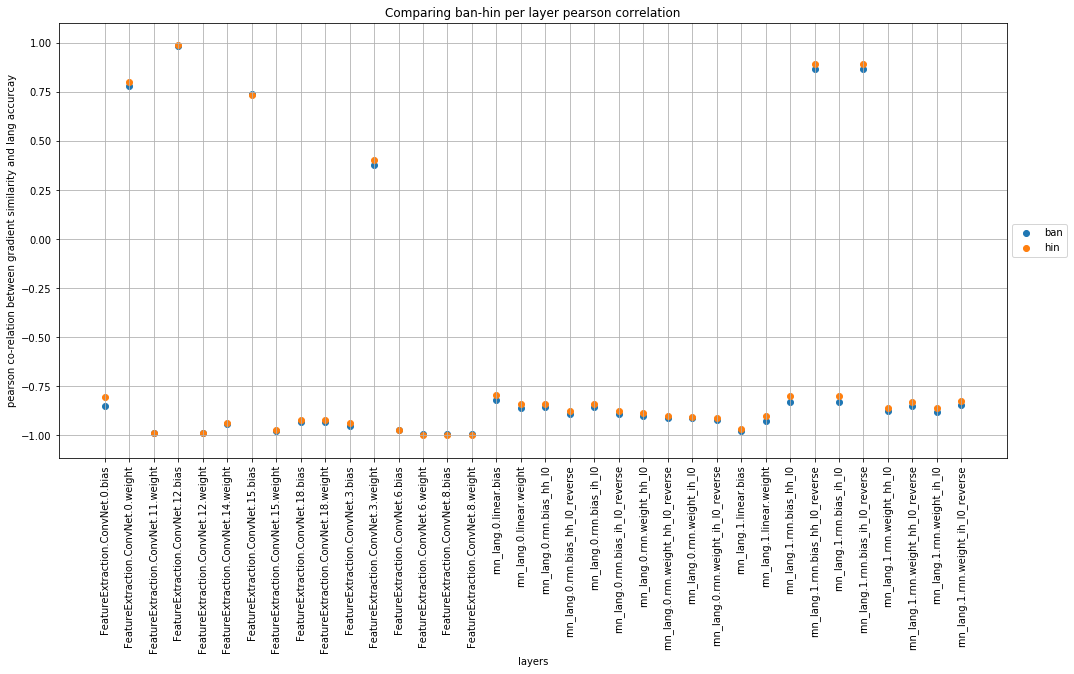

In [20]:
plot_pearsonc(p_BH_B,'ban',p_BH_H,'hin')

## 1.3 Comparing arab-ban per layer pearson correlation

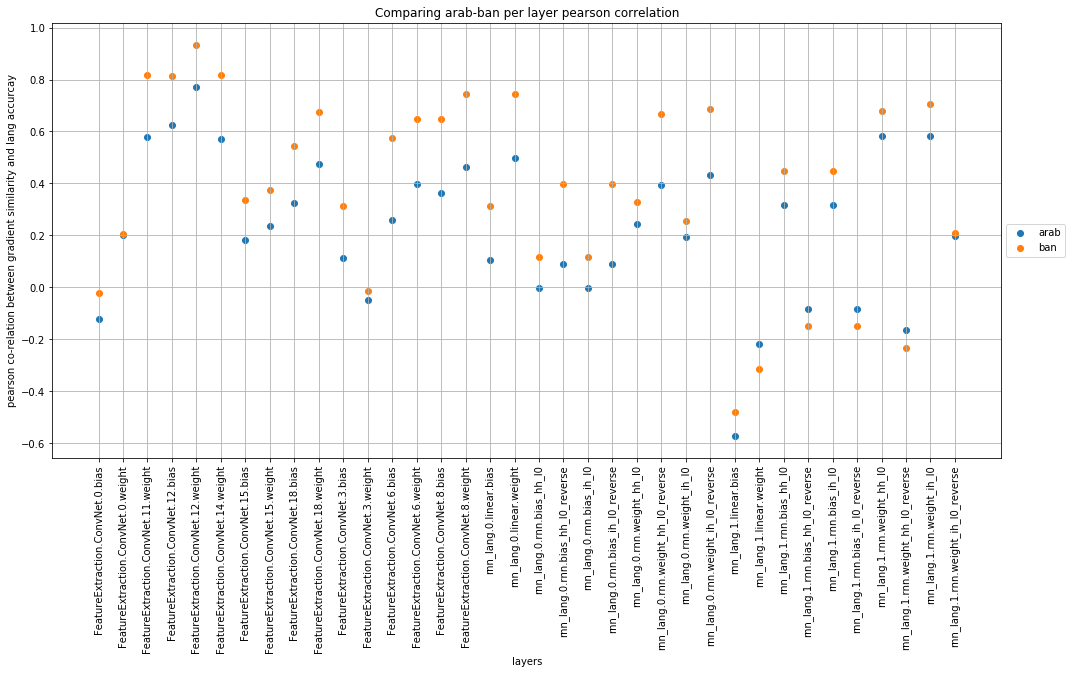

In [19]:
plot_pearsonc(p_AB_A,'arab',p_AB_B,'ban')

## 1.4 Computing Distance between PC vectors of lang pairs

In [21]:
pearson_norm_AB = norm1(list(p_AB_A.values()),list(p_AB_B.values()))
pearson_norm_BH = norm1(list(p_BH_B.values()),list(p_BH_H.values()))
pearson_norm_AH = norm1(list(p_AH_A.values()),list(p_AH_H.values()))
#pearson_norm_BH_trainAB = norm1(p_hinacc,p_arabacc)
print('norm between pearson correlation vectors of arab and bangla [training on Arab-Bangla]:',pearson_norm_AB)
print('norm between pearson correlation vectors of hindi and bangla [training on Hindi-Bangla]:',pearson_norm_BH)
print('norm between pearson correlation vectors of hindi and arab [training on Hindi-Arab]:',pearson_norm_AH)

norm between pearson correlation vectors of arab and bangla [training on Arab-Bangla]: 0.028862099516870687
norm between pearson correlation vectors of hindi and bangla [training on Hindi-Bangla]: 0.0001495229246138985
norm between pearson correlation vectors of hindi and arab [training on Hindi-Arab]: 0.006417824827539831


# 2.0 Single-Task Acc GradSim  Pearson Correlation (STAGS-PC)  

In [20]:
arab_acc = [4.362,12.234,17.234,21.915,28.191,27.553,30.851,26.915,34.787,35.957]
ban_acc = [30.496,36.976,42.186,43.202,46.125,44.091,45.743,45.489,45.743,45.997] 
hin_acc = [16.837,41.454,39.923,42.347,42.347,43.622,45.791,43.750,45.153,41.709]

In [24]:
grads_arab = torch.load('lang_grads_arab.pth')
grads_ban = torch.load('lang_grads_ban.pth')
grads_hin = torch.load('lang_grads_hin.pth')
grads_ban = grads_ban['gradients']
grads_arab = grads_arab['gradients']
grads_hin = grads_hin['gradients']



In [ ]:
check_para_equal(grads_hin[0],grads_hin[2])

In [ ]:
sims_AB = {}
sims_AH = {}
sims_BH = {}
for name in grads_ban[0].keys():
    if 'Predictions' not in name:
        sims_AB[name] = []
        sims_AH[name] = []
        sims_BH[name] = []

find_sims(sims_AB,grads_arab,grads_ban)
find_sims(sims_AH,grads_arab,grads_hin)
find_sims(sims_BH,grads_hin,grads_ban)

    
#sims_BH
#sims_AB

In [ ]:
def find_sims(sims,grads1,grads2):
    for grad1,grad2 in zip(grads1,grads2):
        gradient_similarity(sims,grad1,grad2)

    

### Gradient similarity plot Arab and Bangla (single task)

In [ ]:
multiplot(x,sims_AB)

### Gradient similarity plot Hindi and Bangla (single task)

In [ ]:
multiplot(x,sims_BH)

In [ ]:
ps_AB_A, ps_AB_B = compute_per_layer_pearsonc(sims_AB,arab_acc,ban_acc)
ps_BH_B, ps_BH_H = compute_per_layer_pearsonc(sims_BH,ban_acc,hin_acc)
#ps_AB_A
#ps_AB_B

In [ ]:
plot_pearsonc(ps_AB_A,'arab',ps_AB_B,'ban')

In [ ]:
plot_pearsonc(ps_BH_B,'ban',ps_BH_H,'hin')